<a href="https://colab.research.google.com/github/serg-boykov/trend-prediction-final-version/blob/main/Prediction_of_Trend_Creating_Final_Version_of_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Тема:**
# Предсказание тренда валютной пары EURUSD.


---


# **Описание задачи:**
# Создание торговой системы для извлечения прибыли.


---



# **2. База данных:**

В торговом терминале Metatrader4 через меню Файл была сохранена история котировок валютной пары EURUSD таймфрейма D1, начиная с 04.01.1999 по 07.03.2023, в файл EURUSD1440.csv.


---

Файл содержит данные дневных котировок по столбцам:

*Date, Time, Open, High, Low, Close, Volume.*


---


**Пример из базы:**

1999.01.04, 00:00, 1.18010, 1.18620, 1.17690, 1.18150, 3858

1999.01.05, 00:00, 1.18150, 1.18350, 1.17500, 1.17580, 4793

1999.01.06, 00:00, 1.17610, 1.17730, 1.15530, 1.16230, 4828

…

2023.03.03, 00:00, 1.05954, 1.06380, 1.05877, 1.06322, 85556

2023.03.06, 00:00, 1.06245, 1.06937, 1.06215, 1.06824, 78137

2023.03.07, 00:00, 1.06776, 1.06938, 1.05548, 1.05563, 93157


---
Всего 6284 записи.

Файл EURUSD1440.csv, в котором хранится история котировок валютной пары EURUSD таймфрейма D1 с 04.01.1999 по 07.03.2023, был импортирован в таблицу Excel и сохранён в файл EURUSD1440_1999-2023.xlsx.

# **3. Прогнозирование тренда валютной пары EURUSD**

### Загрузка библиотек

In [ ]:
# Загрузка библиотек

# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv1D, Conv2D
from tensorflow.keras.layers import LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

### Сервисные функции

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(8, 8)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Задание размера шрифта по умолчанию для текста в клетках матрицы
    old_font_size = rcParams['font.size']
    rcParams['font.size'] = 30

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    #ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    ax.set_title(f'Тестирование модели на проверочной выборке', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, cmap='cividis')
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    plt.xticks(fontsize=12)
    plt.xlabel('Предсказанные значения', fontsize=16)
    plt.yticks(fontsize=12)
    plt.ylabel('Верные значения', fontsize=16)
    plt.show()    

    # Восстановление размера шрифта по умолчанию
    rcParams['font.size'] = old_font_size


# Функция обучения модели и отрисовки прогресса и оценки результатов 
# На входе - модель, генераторы обучающей и проверочной выборок
# и список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...].
# Модель последовательно обучается в течение epochs1 эпох с оптимизатором opt1 и т.д.
def train_eval_model(model, x_train, y_train, epoch_list,
                     x_val, y_val, x_test, y_test, title=''):
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='binary_crossentropy',
                      metrics=['accuracy'],
                      optimizer=opt)
        
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(x_train, y_train,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            verbose=1)


        # Рисование графиков прошедшей фазы обучения
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax1.set_title(f'{title}: График прогресса обучения')
        ax1.plot(history.history['loss'], color='blue', label='Ошибка на обучающем наборе')
        ax1.plot(history.history['val_loss'], color='red', label='Ошибка на проверочном наборе')
        ax1.set_ylabel('Средняя ошибка')
        ax1.legend()

        ax2.plot(history.history['accuracy'], color='blue', label='Точность на обучающем наборе')
        ax2.plot(history.history['val_accuracy'], color='red', label='Точность на проверочном наборе')
        ax2.set_ylabel('Точность классификации')
        ax2.legend()

        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_model(model, x_val, y_val, title=title)

        # Рисование графиков оценки результата предсказания на тестовой выборке
        show_predictions_matrix(model, x_test, y_test)

In [ ]:
# Функция разделения набора данных на выборки для обучения нейросети 
# x_data - набор входных данных
# y_data - набор выходных данных
# seq_len - длина серии (подпоследовательности) входных данных для анализа
# predict_lag - количество шагов в будущее для предсказания

def split_sequence(x_data, y_data, seq_len, predict_lag):
    # Определение максимального индекса начала подпоследовательности
    x_len = x_data.shape[0] - seq_len - (predict_lag - 1)
    # Формирование подпоследовательностей входных данных
    x = [x_data[i:i + seq_len] for i in range(x_len)]
    # Формирование меток выходных данных, 
    # отстоящих на predict_lag шагов после конца подпоследовательности
    y = [y_data[i + seq_len + predict_lag - 1] for i in range(x_len)]
    # Возврат результатов в виде массивов numpy
    return np.array(x), np.array(y)

In [ ]:
# Вывод статистики правильных и неправильных предсказаний

def show_predictions_matrix(model, x_test, y_test):
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import numpy as np

    # получаем предсказания модели на тестовой выборке
    predictions = model.predict(x_test)

    # преобразуем многомерный массив predictions в многоклассовую метку
    predictions = np.argmax(predictions, axis=1)

    # преобразуем многомерный массив y_test в многоклассовую метку
    y_test = np.argmax(y_test, axis=1)

    # выводим размерности массивов
    print('Размерность массива predictions:\t', predictions.shape)
    print('Размерность массива y_test:\t', y_test.shape)

    fig, ax = plt.subplots(figsize=(8, 8))
    #ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    ax.set_title(f'Предсказания модели на тестовой выборке', fontsize=18)

    # выводим график матрицы ошибок
    cm = confusion_matrix(y_test, predictions)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    #plt.title('Предсказания модели на тестовой выборке')
    # plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))

    plt.xticks(tick_marks, np.unique(y_test), rotation=45, fontsize=14, color='black')
    plt.yticks(tick_marks, np.unique(y_test), fontsize=14, color='black')

    #plt.subplots_adjust(right=0.9) # смещение матрицы вправо на 10% ширины графика

    #plt.tight_layout()
    plt.ylabel('Фактические значения', fontsize=16, color='black')
    plt.xlabel('Предсказанные значения', fontsize=16, color='black')


    # Настройки цветовой гаммы и шрифта
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm_normalized.max() / 2
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, format(cm_normalized[i, j], '0.1%'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black",
                    fontsize=16)    

    # выводим статистику правильных и неправильных предсказаний
    accuracy = accuracy_score(y_test, predictions)
    print('Точность предсказания: {:.2f}%'.format(accuracy * 100))
    print('Количество правильных ответов:', np.sum(predictions == y_test))
    print('Количество неправильных ответов:', np.sum(predictions != y_test))


## Загрузка датасета и подготовка данных

In [ ]:
# Загрузка датасета из облака.

# История котировок валютной пары EURUSD таймфрейма D1 с 04.01.1999 по 07.03.2023
url = 'https://drive.google.com/uc?id=1SOwyDlyHtJv347i12918WQIBZgY6poxT'
output = 'EURUSD1440.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SOwyDlyHtJv347i12918WQIBZgY6poxT
To: /content/EURUSD1440.csv
100%|██████████| 351k/351k [00:00<00:00, 54.3MB/s]


'EURUSD1440.csv'

Перевод данных в DataFrame

In [ ]:
# Чтение данных в таблицу pandas и назначение имен столбцов
data = pd.read_csv('EURUSD1440.csv', sep=',', names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

Настройка столбцов и интервала данных. Просмотр содержимого таблицы

In [ ]:
# Настройка имен столбцов
COL_DATE = 'Date'
COL_CLOSE = 'Close'

# Настройка временного интервала для ограничения данных
#TIME_RANGE = ('2010-09-01', '2018-12-31') # Часть данных
TIME_RANGE = ('1999-01-03', '2023-03-08') # Все данные

In [ ]:
# Преобразование столбца даты в индекс таблицы и удаление ненужного столбца времени
data.index = pd.to_datetime(data[COL_DATE])
data.drop(columns=COL_DATE, inplace=True)
data.drop(columns='Time', inplace=True)

# Отбор данных по заданному временному интервалу
mask = (data.index >= TIME_RANGE[0]) & (data.index <= TIME_RANGE[1])
data = data[mask]
data

,Open,High,Low,Close,Volume
Date,,,,,
1999-01-04,1.18010,1.18620,1.17690,1.18150,3858
1999-01-05,1.18150,1.18350,1.17500,1.17580,4793
1999-01-06,1.17610,1.17730,1.15530,1.16230,4828
1999-01-07,1.16230,1.17350,1.16120,1.17120,5076
1999-01-08,1.17130,1.17200,1.15330,1.15850,5120
...,...,...,...,...,...
2023-03-01,1.05756,1.06909,1.05648,1.06688,94894
2023-03-02,1.06645,1.06722,1.05758,1.05966,97865
2023-03-03,1.05954,1.06380,1.05877,1.06322,85556


## Иллюстрация данных в графическом виде

Вывод графика цены CLOSE

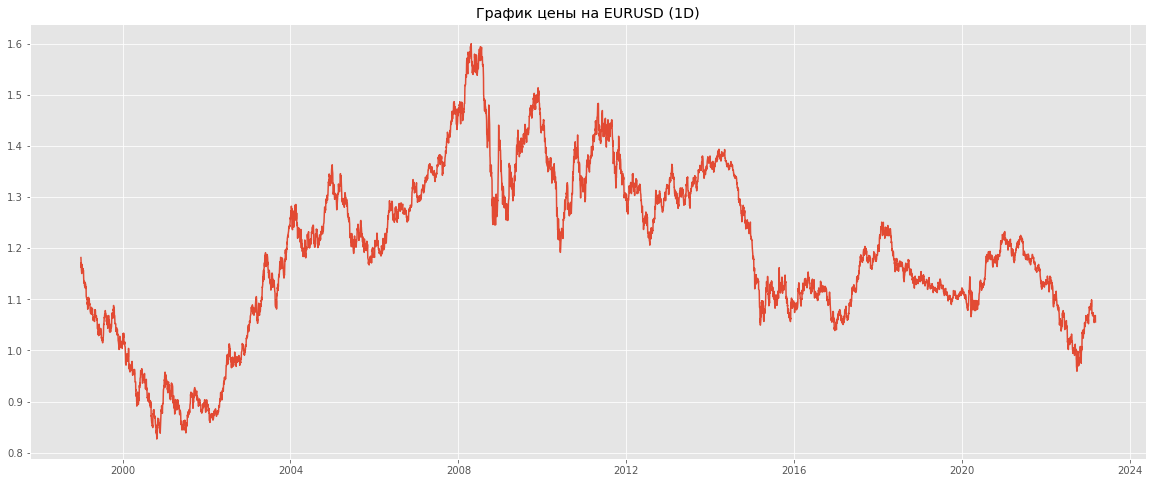

In [ ]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data.index, data[COL_CLOSE])
plt.title('График цены на EURUSD (1D)')
plt.show()

## Подготовка выборок данных для нейросети

### Задание гиперпараметров

Длина элемента выборки равна 5, а нейронная сеть предсказывает два варианта – Нисходящий или Восходящий тренд (0 или 1) (т.е. цена упадет или вырастет)

Indicator_Depth – В НС будет подаваться не только цена закрытия, но и разница между значениями. Данный параметр показывает насколько глубоко мы будем анализировать разницу в индикаторах.

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 5                       # Глубина расчета индикаторов тренда (шаги) (по умолчанюи 5)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа (по умолчанию 5)
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд

In [ ]:
# создаем копию исходного DataFrame для дальнейших экспериментов с параметрами нейронной модели
data_exp = data.copy()

### Расчет признаков тренда

Добавим дополнительные INDICATOR_DEPTH колонок. При помощи pct_change() получим необходимые значения.

Принцип работы таков: следующее значение делится на предыдущее и вычитается 1.

Логика этих INDICATOR_DEPTH столбцов заключается в том, что происходит фиксация изменения цены закрытия по отношению к INDICATOR_DEPTH предыдущим ценам закрытия.

In [ ]:
# Расчет индикаторов относительной доходности
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    # Относительная доходность в сотых долях за период i шагов назад
    data[indicator_change] = data[COL_CLOSE].pct_change(i)

# Проверка результата
print(data.shape)
data[:5]

(6284, 10)


,Open,High,Low,Close,Volume,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5
Date,,,,,,,,,,
1999-01-04,1.1801,1.1862,1.1769,1.1815,3858,NaN,NaN,NaN,NaN,NaN
1999-01-05,1.1815,1.1835,1.1750,1.1758,4793,-0.004824,NaN,NaN,NaN,NaN
1999-01-06,1.1761,1.1773,1.1553,1.1623,4828,-0.011482,-0.016251,NaN,NaN,NaN
1999-01-07,1.1623,1.1735,1.1612,1.1712,5076,0.007657,-0.003912,-0.008718,NaN,NaN
1999-01-08,1.1713,1.1720,1.1533,1.1585,5120,-0.010844,-0.003269,-0.014713,-0.019467,NaN


In [ ]:
# Удаление строк с неполными данными, в которых есть NaN (это будут первые 5 строк):

data.dropna(inplace=True)

# Проверка результата
print(data.shape)
data[:5]

(6279, 10)


,Open,High,Low,Close,Volume,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5
Date,,,,,,,,,,
1999-01-11,1.1575,1.1610,1.1487,1.1503,4960,-0.007078,-0.017845,-0.010324,-0.021687,-0.026407
1999-01-12,1.1504,1.1580,1.1447,1.1555,5248,0.004521,-0.002590,-0.013405,-0.005850,-0.017265
1999-01-13,1.1561,1.1790,1.1553,1.1681,6623,0.010904,0.015474,0.008287,-0.002647,0.004990
1999-01-14,1.1673,1.1728,1.1614,1.1681,5472,0.000000,0.010904,0.015474,0.008287,-0.002647
1999-01-15,1.1683,1.1749,1.1552,1.1563,6529,-0.010102,-0.010102,0.000692,0.005216,-0.001899


Возможны два варианта формирования выборки: подавать данные как есть, либо заменить значения на 0, где значение отрицательное и на 1, где положительное.
Попробуем второй вариант и заменим на 0 и 1.

In [ ]:
# Вычисление индикаторов направления тренда
for i in range(1, INDICATOR_DEPTH + 1):
    indicator_change = f'Close_chng_{i}'
    indicator_trend = f'Y_{i}'
    # Заполнение столбца индикатора тренда нулями (нисходящий/боковой тренд)
    data[indicator_trend] = 0.
    # Если индикатор изменения периода на i шагов положителен, то тренд восходящий
    data.loc[data[indicator_change] > 0. , indicator_trend] = 1.

# Проверка результата
print(data.shape)
data[:5]

(6279, 15)


,Open,High,Low,Close,Volume,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Y_1,Y_2,Y_3,Y_4,Y_5
Date,,,,,,,,,,,,,,,
1999-01-11,1.1575,1.1610,1.1487,1.1503,4960,-0.007078,-0.017845,-0.010324,-0.021687,-0.026407,0.0,0.0,0.0,0.0,0.0
1999-01-12,1.1504,1.1580,1.1447,1.1555,5248,0.004521,-0.002590,-0.013405,-0.005850,-0.017265,1.0,0.0,0.0,0.0,0.0
1999-01-13,1.1561,1.1790,1.1553,1.1681,6623,0.010904,0.015474,0.008287,-0.002647,0.004990,1.0,1.0,1.0,0.0,1.0
1999-01-14,1.1673,1.1728,1.1614,1.1681,5472,0.000000,0.010904,0.015474,0.008287,-0.002647,0.0,1.0,1.0,1.0,0.0
1999-01-15,1.1683,1.1749,1.1552,1.1563,6529,-0.010102,-0.010102,0.000692,0.005216,-0.001899,0.0,0.0,1.0,1.0,0.0


### Формирование входных данных

In [ ]:
x_col = [COL_CLOSE] + [f'Y_{i}' for i in range(1, INDICATOR_DEPTH + 1)]
x_data = data[x_col].values

# Проверка результата
print(x_data.shape, type(x_data))

(6279, 6) <class 'numpy.ndarray'>


### Формирование выходных данных

In [ ]:
indicator_name = f'Y_{INDICATOR_DEPTH}'
y_class = data[indicator_name]

# Проверка результата
y_class[:5]

Date
1999-01-11    0.0
1999-01-12    0.0
1999-01-13    1.0
1999-01-14    0.0
1999-01-15    0.0
Name: Y_5, dtype: float64

In [ ]:
# Кодирование признака класса в one hot encoding
y_data = to_categorical(y_class)

# Проверка результата
print(y_data.shape)
y_data[:5]

(6279, 2)


array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Разделение данных на обучающую, проверочную и тестовую выборки

In [ ]:
INDEX_TRAIN_TO = -VAL_LEN-2*SEQ_LEN-TEST_LEN

INDEX_VAL_FROM = -VAL_LEN-SEQ_LEN-TEST_LEN
INDEX_VAL_TO = -SEQ_LEN-TEST_LEN

INDEX_TEST_FROM = -TEST_LEN

x_train_data, y_train_data = x_data[:INDEX_TRAIN_TO], y_data[:INDEX_TRAIN_TO]
x_val_data, y_val_data = x_data[INDEX_VAL_FROM:INDEX_VAL_TO], y_data[INDEX_VAL_FROM:INDEX_VAL_TO]
x_test_data, y_test_data = x_data[INDEX_TEST_FROM:], y_data[INDEX_TEST_FROM:]

# Проверка результата
print('train_data: ', x_train_data.shape, y_train_data.shape,
      '\nval_data:  ', x_val_data.shape, y_val_data.shape,
      '\ntest_data:  ', x_test_data.shape, y_test_data.shape,
      '\nОбщая длина:', x_train_data.shape[0] + x_val_data.shape[0] + x_test_data.shape[0])

train_data:  (5069, 6) (5069, 2) 
val_data:   (600, 6) (600, 2) 
test_data:   (600, 6) (600, 2) 
Общая длина: 6269


### Масштабирование входных данных

In [ ]:
x_scaler = StandardScaler()
x_scaler.fit(x_train_data)
x_train_data = x_scaler.transform(x_train_data)
x_val_data = x_scaler.transform(x_val_data)
x_test_data = x_scaler.transform(x_test_data)

# Проверка результата
print(x_train_data.shape, x_val_data.shape, x_test_data.shape, type(x_train_data))

# Вывод последней строки в проверочном наборе данных после масштабирования
x_val_data[-1:]

(5069, 6) (600, 6) (600, 6) <class 'numpy.ndarray'>


array([[-0.11958157,  0.98803761,  0.99468762,  0.97563699,  0.98375785,
         0.99077054]])

### Формирование выборок для нейросети

In [ ]:
# Формирование выборок для обучения нейросети
x_train, y_train = split_sequence(x_train_data, y_train_data, SEQ_LEN, PREDICT_LAG)
x_val, y_val = split_sequence(x_val_data, y_val_data, SEQ_LEN, PREDICT_LAG)
x_test, y_test = split_sequence(x_test_data, y_test_data, SEQ_LEN, PREDICT_LAG)

# Проверка результата
print('Массивы x_train и y_train:\t', x_train.shape, y_train.shape)
print('Массивы x_val и y_val:\t\t', x_val.shape, y_val.shape)
print('Массивы x_test и y_test:\t', x_test.shape, y_test.shape)

Массивы x_train и y_train:	 (5064, 5, 6) (5064, 2)
Массивы x_val и y_val:		 (595, 5, 6) (595, 2)
Массивы x_test и y_test:	 (595, 5, 6) (595, 2)


## Модель нейронной сети для обработки валютной пары EURUSD

In [ ]:
# Входной слой
input = Input(shape=x_train.shape[1:])
# Преобразование в одномерный вектор
x = Flatten()(input)
# Повтор вектора несколько раз
x = RepeatVector(4)(x)
# Одномерная свертка
x = Conv1D(SEQ_LEN * 2, 5, padding='same', activation='relu')(x)
# Макспулинг и понижение размерности
x = MaxPooling1D(pool_size=2)(x)
# Преобразование в одномерный вектор
x = Flatten()(x)
# Слой RepeatVector() построчно копирует вектор указанное количество раз
x = RepeatVector(4)(x)
# Одномерная свертка
x = Conv1D(SEQ_LEN, 5, padding='same', activation='relu')(x)
# Макспулинг и понижение размерности
x = MaxPooling1D(pool_size=2)(x)
# Преобразование в одномерный вектор
x = Flatten()(x)
# Полносвязный слой
x = Dense(SEQ_LEN * 100, activation='relu')(x)
# Слой регуляризации
x = Dropout(0.4)(x)
# Финальный слой классификатора
x = Dense(y_train.shape[1], activation='sigmoid')(x)

# Сборка модели из входа и выхода
model = Model(input, x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 6)]            0         
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 4, 30)            0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 4, 10)             1510      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 10)            0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 20)                0     

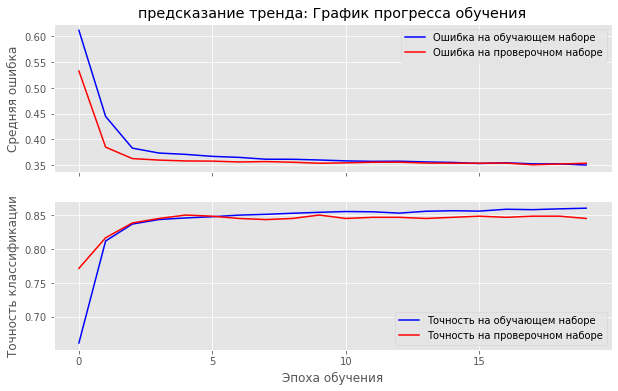

19/19 [==============================] - 0s 2ms/step


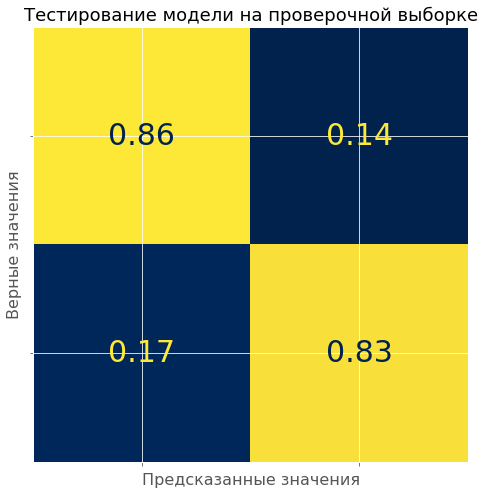

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 83.03%
Количество правильных ответов: 494
Количество неправильных ответов: 101


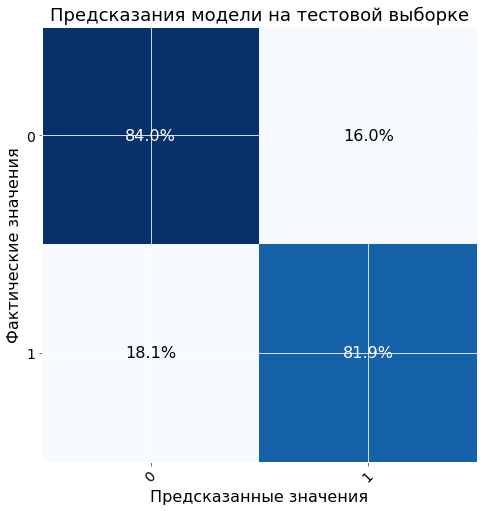

In [ ]:
# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(20, Adam(learning_rate=1e-04))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

С моделью нейронной сети были проведены: обучение, проверка и тестирование с целью предсказания тренда на валютной паре EURUSD.

Графики: средняя ошибка, точность классификации, матрица оценки результатов по тестированию модели на проверочной выборке, матрица оценки результатов по предсказанию модели на тестовой выборке.

Все графики дали удовлетворительные результаты, но нужно провести ряд экспериментов, чтобы найти максимально оптимальные параметры.

У нас есть такие параметры нейросети:

In [ ]:
# Гиперпараметры

INDICATOR_DEPTH = 5                       # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)

Будем экспериментировать только с двумя параметрами как самыми важными для улучшения результатов прогнозирования тренда:

INDICATOR_DEPTH и SEQ_LEN

Будем их изменять по очереди...

Для удобства проведения экспериментов и дальнейшего использования сделаем:

функцию построения нейронной модели и функцию предобработки данных

## Функция построения нейронной модели

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, RepeatVector, Conv1D, MaxPooling1D, Dropout

def build_model(input_shape, output_shape, seq_len):
    # Входной слой
    input = Input(shape=input_shape)
    # Преобразование в одномерный вектор
    x = Flatten()(input)
    # Повтор вектора несколько раз
    x = RepeatVector(4)(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 2, 5, padding='same', activation='relu')(x)
    # Макспулинг и понижение размерности
    x = MaxPooling1D(pool_size=2)(x)
    # Преобразование в одномерный вектор
    x = Flatten()(x)
    # Слой RepeatVector() построчно копирует вектор указанное количество раз
    x = RepeatVector(4)(x)
    # Одномерная свертка
    x = Conv1D(seq_len, 5, padding='same', activation='relu')(x)
    # Макспулинг и понижение размерности
    x = MaxPooling1D(pool_size=2)(x)
    # Преобразование в одномерный вектор
    x = Flatten()(x)
    # Полносвязный слой
    x = Dense(seq_len * 100, activation='relu')(x)
    # Слой регуляризации
    x = Dropout(0.4)(x)
    # Финальный слой классификатора
    x = Dense(output_shape, activation='sigmoid')(x)

    # Сборка модели из входа и выхода
    model = Model(input, x)
    return model

## Функция предобработки данных

In [ ]:
# Функция предобработки данных для модели предсказания направления тренда

def preprocess_data(data_in, indicator_depth=40, seq_len=10, val_len=600, test_len=600, col_price='Close', predict_lag=1):
    """
    Функция предобработки данных для модели предсказания направления тренда.

    :param data: pandas.DataFrame, исходный набор данных
    :param indicator_depth: int, глубина расчета индикаторов относительной доходности
    :param seq_len: int, длина последовательности
    :param val_len: int, длина проверочной выборки
    :param test_len: int, длина тестовой выборки
    :param col_price: str, наименование столбца с ценой (Open, High, Low, Close)
    :param predict_lag: int, задержка предсказания
    :return: tuple, обучающие и проверочные выборки для модели
    """

    data = data_in.copy()

    # Расчет индикаторов относительной доходности
    for i in range(1, indicator_depth + 1):
        indicator_change = f'{col_price}_chng_{i}'
        # Относительная доходность за период i шагов назад
        data[indicator_change] = data[col_price].pct_change(i)

    # Удаление строк с неполными данными, в которых есть NaN
    data.dropna(inplace=True)

    # Вычисление индикаторов направления тренда
    for i in range(1, indicator_depth + 1):
        indicator_change = f'{col_price}_chng_{i}'
        indicator_trend = f'Y_{i}'
        # Заполнение столбца индикатора тренда нулями (нисходящий/боковой тренд)
        data[indicator_trend] = 0.
        # Если индикатор изменения периода на i шагов положителен, то тренд восходящий
        data.loc[data[indicator_change] > 0., indicator_trend] = 1.

    # Формирование входных данных
    x_col = [col_price] + [f'Y_{i}' for i in range(1, indicator_depth + 1)]
    x_data = data[x_col].values

    # Формирование выходных данных
    indicator_name = f'Y_{indicator_depth}'
    y_class = data[indicator_name]

    # Кодирование признака класса в one hot encoding
    y_data = to_categorical(y_class)

    # Разделение данных на обучающую и проверочную выборки
    index_train_to = -val_len-2*seq_len-test_len
    index_val_from = -val_len-seq_len-test_len
    index_val_to = -seq_len-test_len
    index_test_from = -test_len

    x_train_data, y_train_data = x_data[:index_train_to], y_data[:index_train_to]
    x_val_data, y_val_data = x_data[index_val_from:index_val_to], y_data[index_val_from:index_val_to]
    x_test_data, y_test_data = x_data[index_test_from:], y_data[index_test_from:]


    # Масштабирование входных данных
    x_scaler = StandardScaler()
    x_scaler.fit(x_train_data)
    x_train_data = x_scaler.transform(x_train_data)
    x_val_data = x_scaler.transform(x_val_data)
    x_test_data = x_scaler.transform(x_test_data)

    # Формирование выборок для обучения нейросети
    x_train, y_train = split_sequence(x_train_data, y_train_data, seq_len, predict_lag)
    x_val, y_val = split_sequence(x_val_data, y_val_data, seq_len, predict_lag)
    x_test, y_test = split_sequence(x_test_data, y_test_data, seq_len, predict_lag)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
# Проверка данных, что они нужного формата
data_exp

,Open,High,Low,Close,Volume
Date,,,,,
1999-01-04,1.18010,1.18620,1.17690,1.18150,3858
1999-01-05,1.18150,1.18350,1.17500,1.17580,4793
1999-01-06,1.17610,1.17730,1.15530,1.16230,4828
1999-01-07,1.16230,1.17350,1.16120,1.17120,5076
1999-01-08,1.17130,1.17200,1.15330,1.15850,5120
...,...,...,...,...,...
2023-03-01,1.05756,1.06909,1.05648,1.06688,94894
2023-03-02,1.06645,1.06722,1.05758,1.05966,97865
2023-03-03,1.05954,1.06380,1.05877,1.06322,85556


## Эксперименты с параметрами нейросети

## Параметр INDICATOR_DEPTH

### Эксперимент №1

INDICATOR_DEPTH = 10

learning_rate = 1e-04

epoch = 20

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 11)]           0         
                                                                 
 flatten_3 (Flatten)         (None, 55)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 4, 55)            0         
 or)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 10)             2760      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 10)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 20)                0   

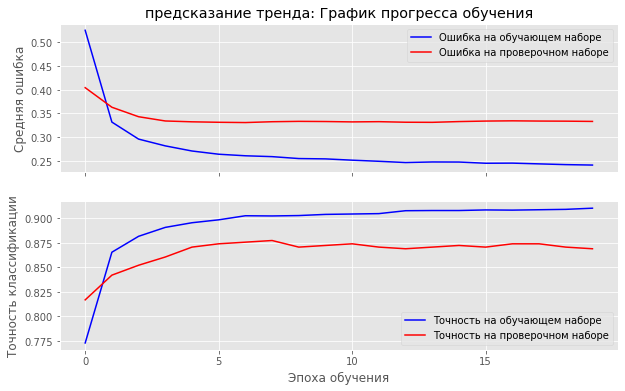

19/19 [==============================] - 0s 2ms/step


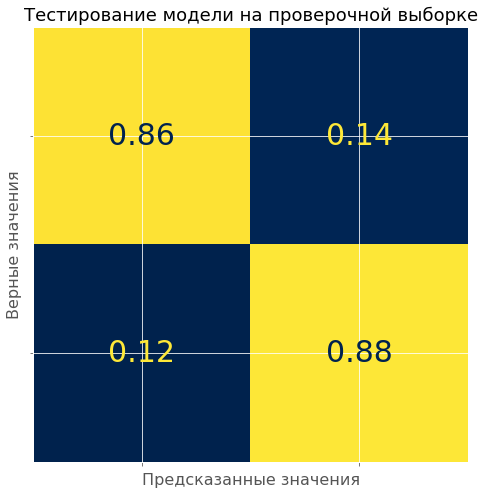

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 88.24%
Количество правильных ответов: 525
Количество неправильных ответов: 70


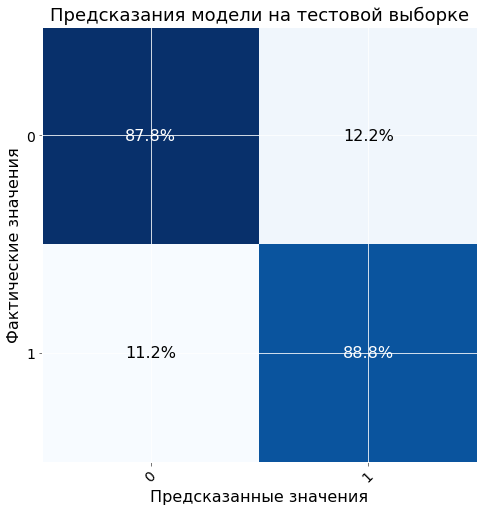

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 10                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(20, Adam(learning_rate=1e-04))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

При увеличении параметра INDICATOR_DEPTH = 10 результаты улучшились.

Можно увеличить ещё этот параметр.

### Эксперимент №2

INDICATOR_DEPTH = 20

learning_rate = 1e-04

epoch = 20

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5, 21)]           0         
                                                                 
 flatten_24 (Flatten)        (None, 105)               0         
                                                                 
 repeat_vector_16 (RepeatVec  (None, 4, 105)           0         
 tor)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 4, 10)             5260      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 2, 10)            0         
 g1D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 20)                0   

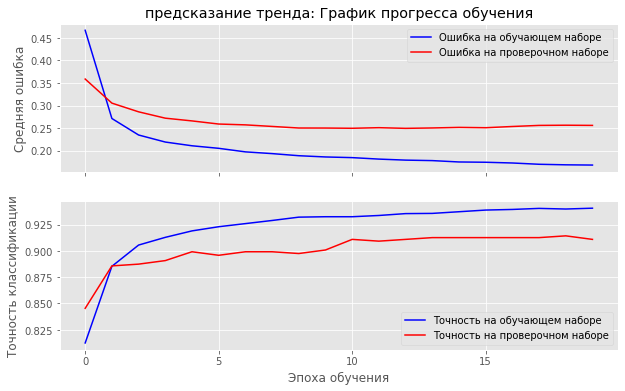

19/19 [==============================] - 0s 2ms/step


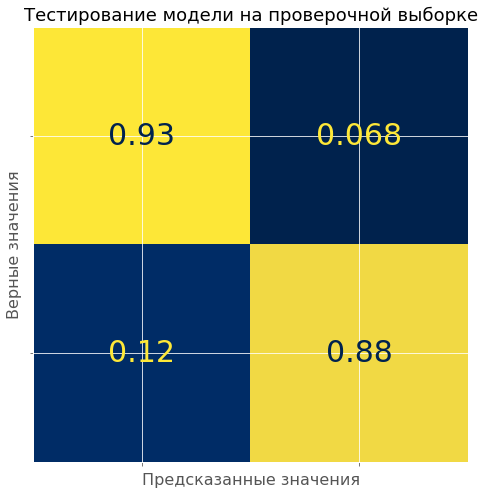

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 92.61%
Количество правильных ответов: 551
Количество неправильных ответов: 44


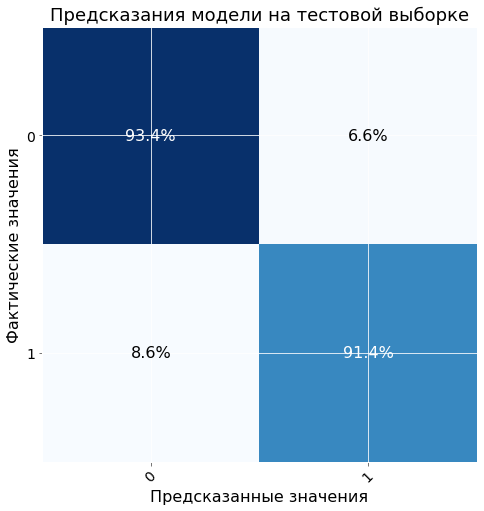

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 20                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(20, Adam(learning_rate=1e-04))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

При увеличении параметра INDICATOR_DEPTH = 20 результаты ещё улучшились.

Но на графике "Средняя ошибка" заметно небольшое наметившееся переобучение.

Скорее всего, этот параметр нет смысла увеличивать на данный момент. Лучше уменьшить шаг обучения.

### Эксперимент №3

INDICATOR_DEPTH = 20

learning_rate = 1e-05

epoch = 20

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 21)]           0         
                                                                 
 flatten_9 (Flatten)         (None, 105)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 4, 105)           0         
 or)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 4, 10)             5260      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2, 10)            0         
 1D)                                                             
                                                                 
 flatten_10 (Flatten)        (None, 20)                0   

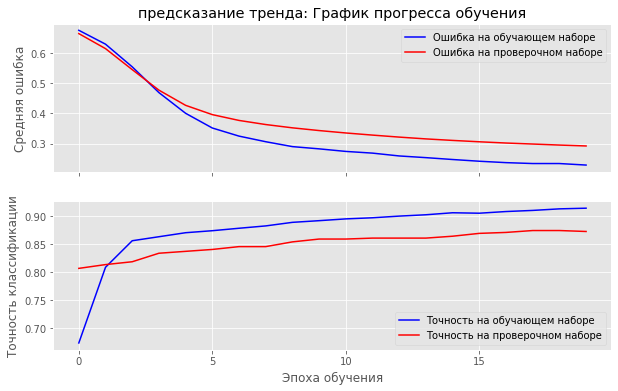

19/19 [==============================] - 0s 2ms/step


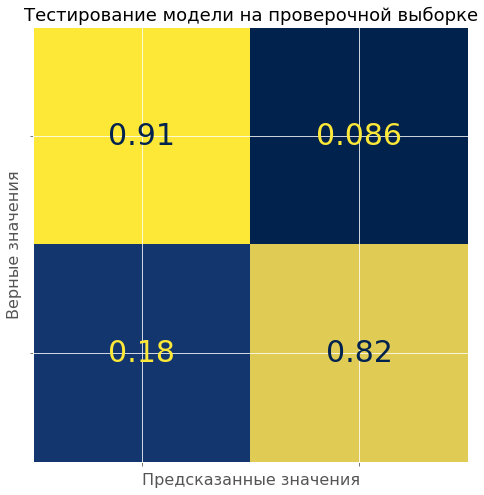

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 90.59%
Количество правильных ответов: 539
Количество неправильных ответов: 56


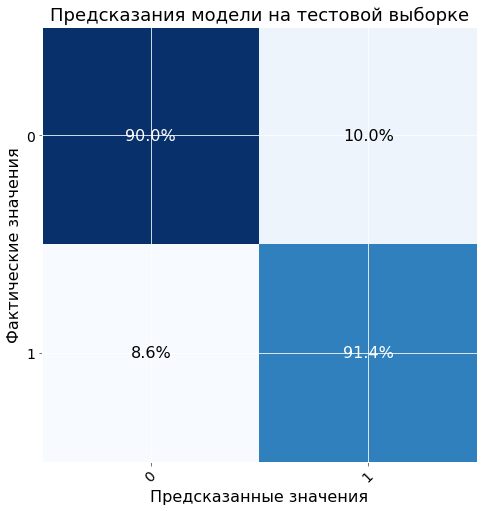

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 20                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(20, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Результаты немного ухудшились.

Но зато на графике "Средняя ошибка" исчезло наметившееся в прошлом эксперименте переобучение.

Теперь можно попробовать ещё увеличить параметр INDICATOR_DEPTH и в то же время увеличить количество эпох обучения.

### Эксперимент №4

INDICATOR_DEPTH = 40

learning_rate = 1e-05

epoch = 30

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 41)]           0         
                                                                 
 flatten_15 (Flatten)        (None, 205)               0         
                                                                 
 repeat_vector_10 (RepeatVec  (None, 4, 205)           0         
 tor)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 4, 10)             10260     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2, 10)            0         
 g1D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 20)                0   

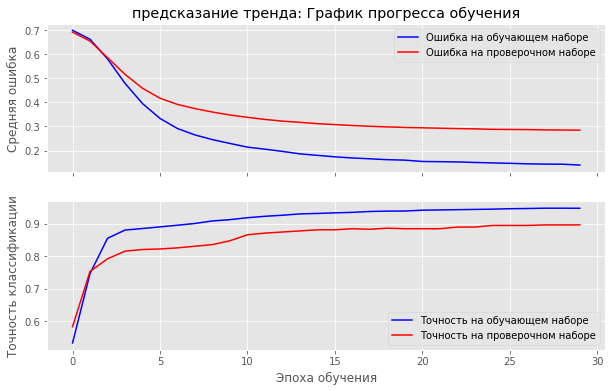

19/19 [==============================] - 0s 2ms/step


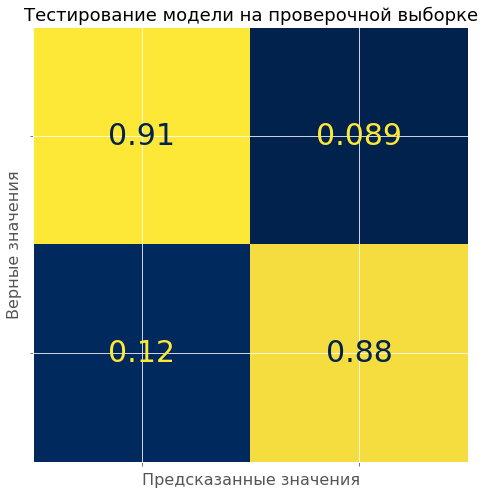

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 95.29%
Количество правильных ответов: 567
Количество неправильных ответов: 28


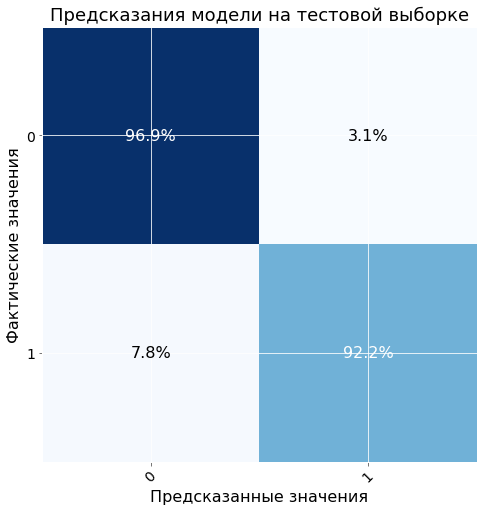

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Рузультаты улучшились. Нет переобучения.

А предсказания на тестовой выборке стали даже лучше, чем результаты на проверочной.

Тогда попробуем ещё увеличить наш параметр.

### Эксперимент №5

INDICATOR_DEPTH = 60

learning_rate = 1e-05

epoch = 30

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 5, 61)]           0         
                                                                 
 flatten_75 (Flatten)        (None, 305)               0         
                                                                 
 repeat_vector_50 (RepeatVec  (None, 4, 305)           0         
 tor)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 4, 10)             15260     
                                                                 
 max_pooling1d_50 (MaxPoolin  (None, 2, 10)            0         
 g1D)                                                            
                                                                 
 flatten_76 (Flatten)        (None, 20)                0  

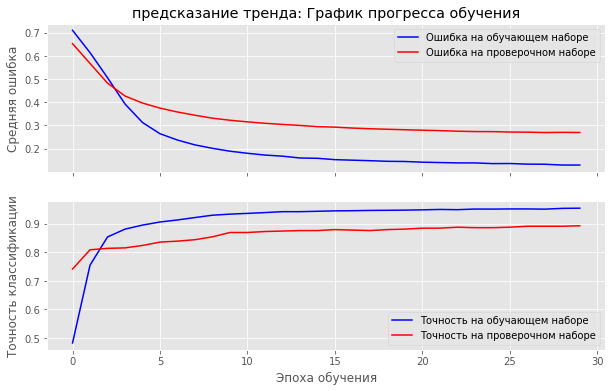

19/19 [==============================] - 0s 3ms/step


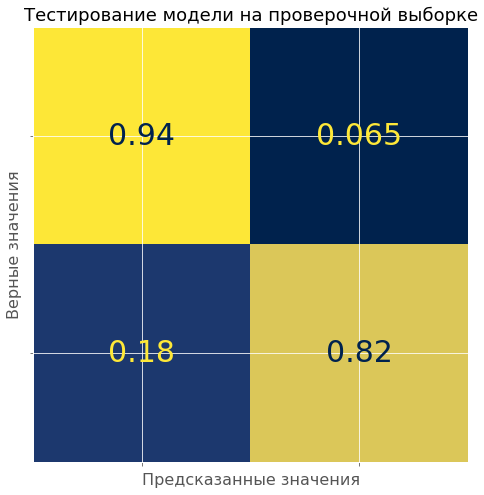

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (595,)
Размерность массива y_test:	 (595,)
Точность предсказания: 96.64%
Количество правильных ответов: 575
Количество неправильных ответов: 20


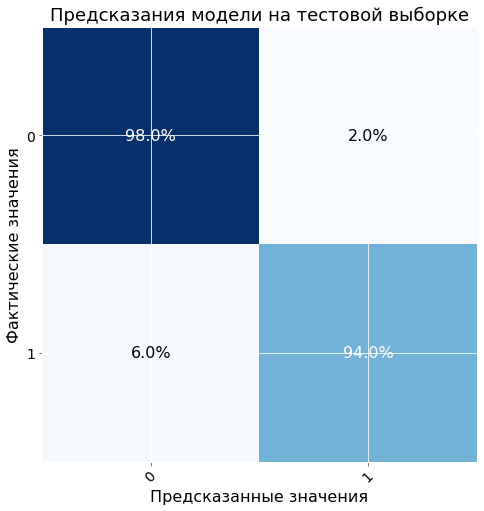

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 60                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 5                               # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Результаты вроде бы неплохие... можно сказать, на том же уровне.

На тестовой выборке показатели даже стали лучше, но вот на проверочной выборке наблюдается сильная разбалансировка результатов предсказаний тренда вверх и вниз.

Пожалуй, эту величину параметра INDICATOR_DEPTH лучше не использовать. Вернёмся на шаг назад и будем использовать параметр INDICATOR_DEPTH = 40.

Перейдём к экспериментам с параметром SEQ_LEN.

## Параметр SEQ_LEN

### Эксперимент №6

INDICATOR_DEPTH = 40

SEQ_LEN = 10

learning_rate = 1e-05

epoch = 30

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 41)]          0         
                                                                 
 flatten_27 (Flatten)        (None, 410)               0         
                                                                 
 repeat_vector_18 (RepeatVec  (None, 4, 410)           0         
 tor)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 4, 20)             41020     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2, 20)            0         
 g1D)                                                            
                                                                 
 flatten_28 (Flatten)        (None, 40)                0   

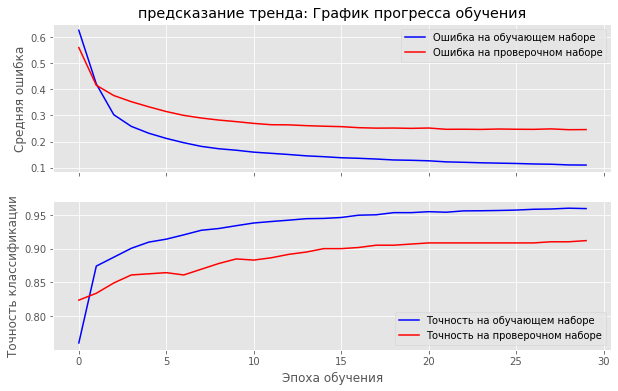

19/19 [==============================] - 0s 3ms/step


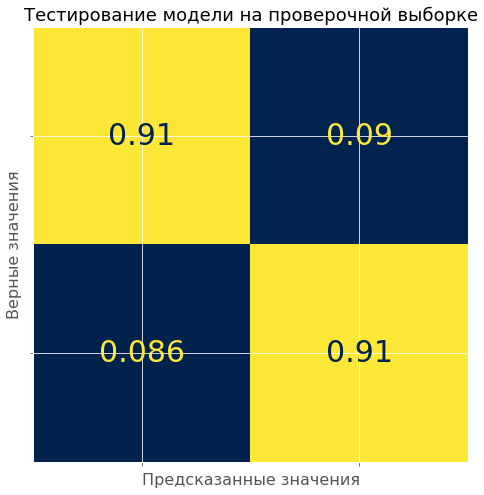

19/19 [==============================] - 0s 2ms/step
Размерность массива predictions:	 (590,)
Размерность массива y_test:	 (590,)
Точность предсказания: 95.76%
Количество правильных ответов: 565
Количество неправильных ответов: 25


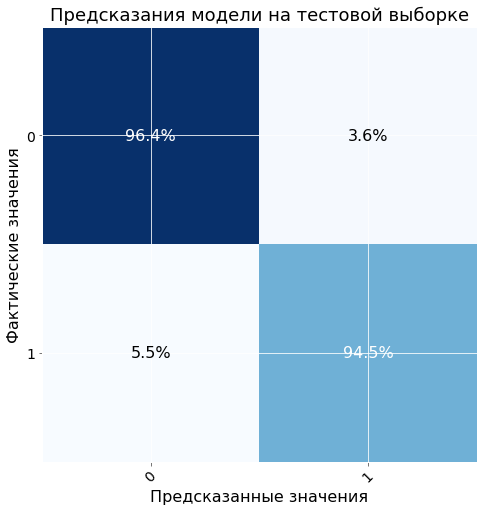

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 10                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Результаты очень хорошие и выглядят сбалансировано как на проверочной выборке, так и на тестовой. А также сбалансированы в обоих выборках в предсказаниях по отношению направления предсказания: тренд вверх или вниз.

Графики средней ошибки и точности классификации тоже выглядт хорошо.

Этот вариант параметров мне нравится :-).

### Эксперимент №7

INDICATOR_DEPTH = 40

SEQ_LEN = 20

learning_rate = 1e-05

epoch = 30

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 20, 41)]          0         
                                                                 
 flatten_78 (Flatten)        (None, 820)               0         
                                                                 
 repeat_vector_52 (RepeatVec  (None, 4, 820)           0         
 tor)                                                            
                                                                 
 conv1d_67 (Conv1D)          (None, 4, 40)             164040    
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 2, 40)            0         
 g1D)                                                            
                                                                 
 flatten_79 (Flatten)        (None, 80)                0  

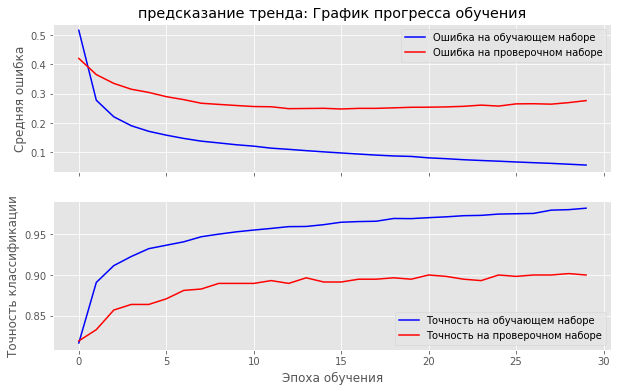

19/19 [==============================] - 0s 7ms/step


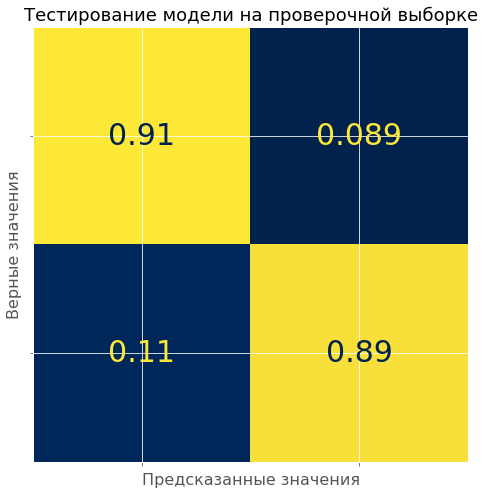

19/19 [==============================] - 0s 4ms/step
Размерность массива predictions:	 (580,)
Размерность массива y_test:	 (580,)
Точность предсказания: 96.38%
Количество правильных ответов: 559
Количество неправильных ответов: 21


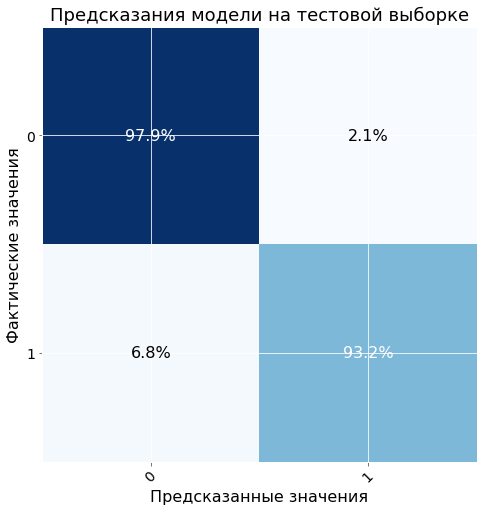

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 20                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Результаты эксперимента несколько противоречивы: на проверочной выборке появилась разбалансировака результатов предсказания тренда вверх или вниз, на тестовой в среднем процент предсказания даже улучшился, но разбалансировка результатов увеличилась.

К тому же на графике Средней Ошибки начало проявляться переобучение.

В общем, лучше эту величину параметра не использовать и вернуться к предыдущей, т.е. SEQ_LEN = 10.

Итак, лучшие параметры:

INDICATOR_DEPTH = 40

SEQ_LEN = 10

Можно попробовать эти параметры протестировать на более мощной нейронной модели.

## Создание более мощной нейросети

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, RepeatVector, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout, BatchNormalization

def build_model_powerful(input_shape, output_shape, seq_len):
    # Входной слой
    input = Input(shape=input_shape)
    # Преобразование в одномерный вектор
    x = Flatten()(input)
    # Повтор вектора несколько раз
    x = RepeatVector(4)(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 2, 5, padding='same', activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 4, 5, padding='same', activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 8, 5, padding='same', activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Макспулинг и понижение размерности
    x = MaxPooling1D(pool_size=4)(x)
    # Преобразование в одномерный вектор
    x = Flatten()(x)
    # Повтор вектора несколько раз
    x = RepeatVector(4)(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 4, 5, padding='same', activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Одномерная свертка
    x = Conv1D(seq_len * 2, 5, padding='same', activation='relu')(x)
    # Batch normalization
    x = BatchNormalization()(x)
    # Макспулинг и понижение размерности
    x = MaxPooling1D(pool_size=4)(x)
    # Преобразование в одномерный вектор
    x = Flatten()(x)
    # Полносвязный слой
    x = Dense(seq_len * 100, activation='relu')(x)
    # Слой регуляризации
    x = Dropout(0.4)(x)
    # Финальный слой классификатора
    x = Dense(output_shape, activation='sigmoid')(x)

    # Сборка модели из входа и выхода
    model = Model(input, x)
    return model

### Эксперимент №8

INDICATOR_DEPTH = 40

SEQ_LEN = 10

learning_rate = 1e-05

epoch = 30

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 10, 41)]          0         
                                                                 
 flatten_81 (Flatten)        (None, 410)               0         
                                                                 
 repeat_vector_54 (RepeatVec  (None, 4, 410)           0         
 tor)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, 4, 20)             41020     
                                                                 
 batch_normalization_25 (Bat  (None, 4, 20)            80        
 chNormalization)                                                
                                                                 
 conv1d_70 (Conv1D)          (None, 4, 40)             404

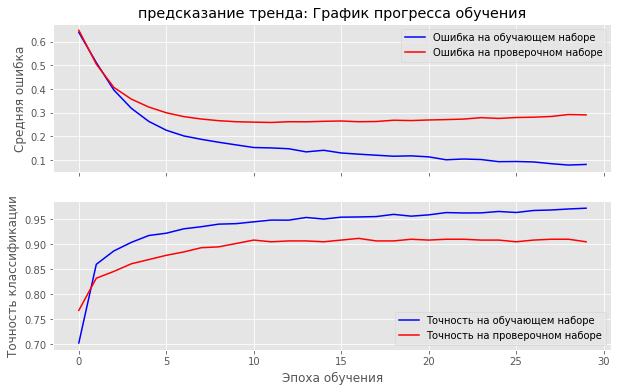

19/19 [==============================] - 0s 4ms/step


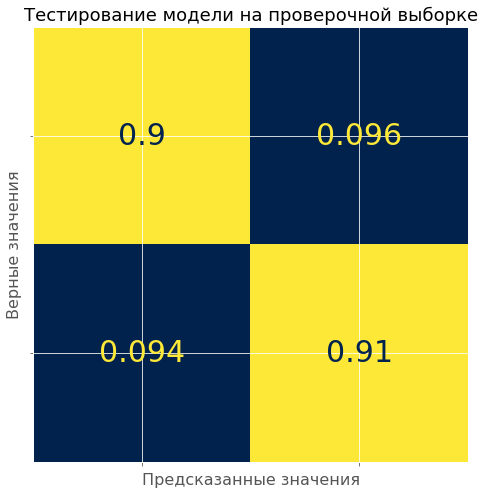

19/19 [==============================] - 0s 3ms/step
Размерность массива predictions:	 (590,)
Размерность массива y_test:	 (590,)
Точность предсказания: 94.75%
Количество правильных ответов: 559
Количество неправильных ответов: 31


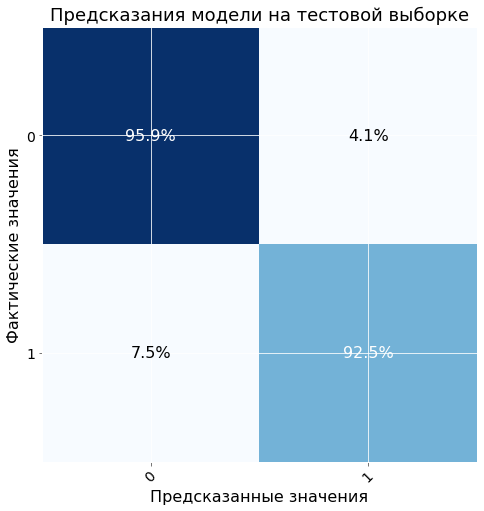

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 10                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model_powerful(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

**Вывод:**

Все показатели несколько ухудшились по сравнению с показателями в эксперименте №6.

К тому же, на графике Средней Ошибки появилось переобучение.

В итоге делаем вывод, что нет никакого смысла в данной задаче по предсказанию тренда использовать более мощную нейронную сеть.

## **Выбор оптимальных параметров**

### **Итоговый вывод:**

После проведения ряда экспериментов выяснили, что оптимальными параметрами являются параметры в эксперименте №6 на первой более простой архитектуре нейронной сети. 

Результаты очень хорошие и выглядят сбалансировано как на проверочной выборке, так и на тестовой по отношению друг к другу по точности предсказаний. А также сбалансированы результаты непосредственно внутри в обоих выборках в плане направлений предсказания: тренд вверх или вниз, т.е. предсказываются с одинаковой точностью.

Графики средней ошибки и точности классификации тоже выглядт хорошо.


---

***Оптимальные параметры:***

INDICATOR_DEPTH = 40

SEQ_LEN = 10


***Дополнительные параметры для обучения:***

learning_rate = 1e-05

epoch = 30


---



## Создание функции для использования готовой нейросети

In [ ]:
def predict_trend(data, model_file, show_plot=False):
    
    from tensorflow import keras

    INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
    SEQ_LEN = 10                              # Длина серии (подпоследовательности) входных данных для анализа
    PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
    VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
    TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
    COL_PRICE = 'Close'                       # Тип цены предсказания ('Open', 'High', 'Low', 'Close'), какой был время обучения

    # вызов функции предобработки данных
    x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_PRICE, PREDICT_LAG)

    # загрузка обученной модели
    model = keras.models.load_model(model_file)

    if show_plot:
        # Рисование графиков оценки результата предсказания на тестовой выборке
        show_predictions_matrix(model, x_test, y_test)

    # предсказание на тестовых данных
    y_pred = model.predict(x_test)

    return y_pred

Ещё раз обучим модель нейросети и сохраним её архитектуру с весами в файл

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 10, 41)]          0         
                                                                 
 flatten_72 (Flatten)        (None, 410)               0         
                                                                 
 repeat_vector_48 (RepeatVec  (None, 4, 410)           0         
 tor)                                                            
                                                                 
 conv1d_63 (Conv1D)          (None, 4, 20)             41020     
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 2, 20)            0         
 g1D)                                                            
                                                                 
 flatten_73 (Flatten)        (None, 40)                0  

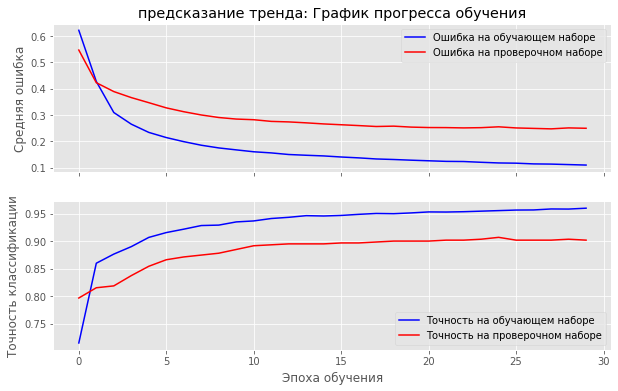

19/19 [==============================] - 0s 2ms/step


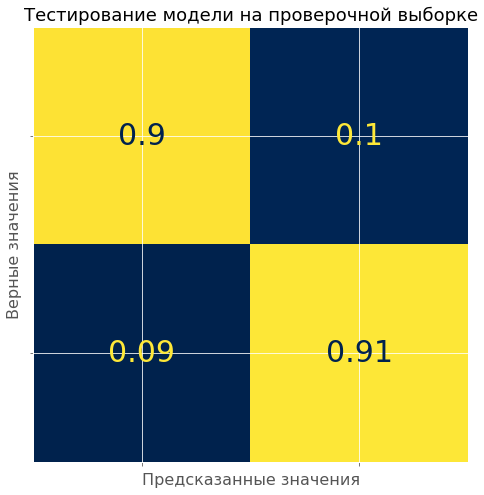

19/19 [==============================] - 0s 3ms/step
Размерность массива predictions:	 (590,)
Размерность массива y_test:	 (590,)
Точность предсказания: 96.27%
Количество правильных ответов: 568
Количество неправильных ответов: 22


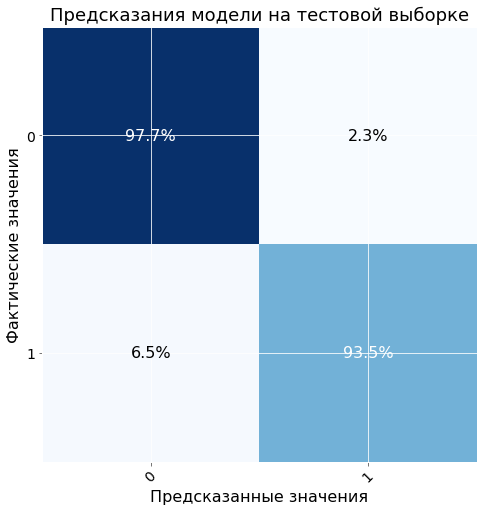

In [ ]:
# Задание гиперпараметров

INDICATOR_DEPTH = 40                      # Глубина расчета индикаторов тренда (шаги)
SEQ_LEN = 10                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания (по умолчанию 1)
VAL_LEN = 600                             # Объем проверочной выборки (по умолчанию 600)
TEST_LEN = 600                            # Объем тестовой выборки (в конце данных) (по умолчанию 600)
CLASS_LABELS = ['Нисходящий/боковой', 
                'Восходящий']             # Метки классов: 0-нисходящий/боковой тренд, 1-восходящий тренд


x_train, y_train, x_val, y_val, x_test, y_test = preprocess_data(data_exp, INDICATOR_DEPTH, SEQ_LEN, VAL_LEN, TEST_LEN, COL_CLOSE, PREDICT_LAG)

model = build_model(x_train.shape[1:], y_train.shape[1], SEQ_LEN)

# Обучение и вывод результатов работы модели
train_eval_model(model, x_train, y_train, [(30, Adam(learning_rate=1e-05))],
                 x_val, y_val, x_test, y_test, title='предсказание тренда')

In [ ]:
# Сохранение модели в файл

model.save('model_predict_trend.h5')

19/19 [==============================] - 0s 6ms/step
Размерность массива predictions:	 (590,)
Размерность массива y_test:	 (590,)
Точность предсказания: 96.27%
Количество правильных ответов: 568
Количество неправильных ответов: 22
19/19 [==============================] - 0s 6ms/step


array([[5.9371442e-04, 9.9945074e-01],
       [7.5568934e-04, 9.9931252e-01],
       [6.9433852e-04, 9.9933952e-01],
       ...,
       [5.6862557e-01, 4.2549410e-01],
       [9.4448382e-01, 5.5631474e-02],
       [9.2824185e-01, 7.5791955e-02]], dtype=float32)

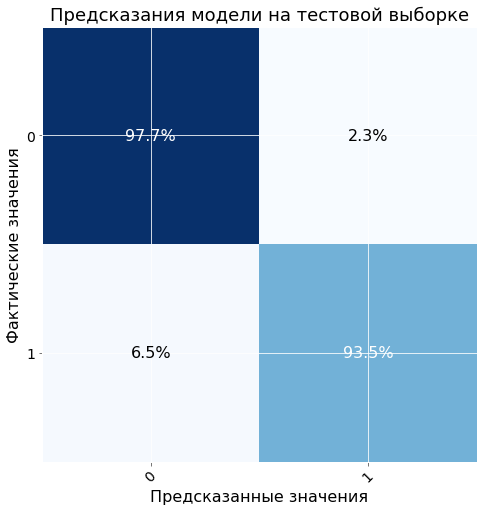

In [ ]:
# Предсказание тренда с выводом матрицы оценки результатов на тестовой выборке

predict_trend(data, 'model_predict_trend.h5', True)

## **Краткий итог дипломной работы по созданию финальной версии нейронной сети**

В рамках данной дипломной работы было проведено исследование с целью предсказания тренда валютной пары EURUSD. Для этого была использована нейронная сеть, которая была обучена на исторических данных о курсах валют.

Было проведено достаточное количество экспериментов с различными параметрами нейронной сети. Каждый эксперимент был детально изучен, и на основе полученных результатов были сделаны соответствующие выводы. Были найдены оптимальные параметры нейросети, которые позволили достичь наилучшего результата при предсказании тренда валютной пары.

В итоге была разработана функция для использования готовой нейронной сети. Она позволяет предсказывать тренд валютной пары на основе текущих данных. Это может быть полезным инструментом для тех, кто занимается торговлей на рынке валют.

Таким образом, данная дипломная работа имеет практическую значимость и может быть использована в реальной жизни для принятия решений в области финансовых инвестиций по валютной паре EURUSD.